# Dynamic Programming Squared Model of the Economy


### Writing and Coding Sample

**Suraj Kumar** 

**Post Graduation**  
*MA Economics(Final Year)*  
*Department of Economics*  
**Delhi School of Economics**  
*India*

**Under graduation**    
*B.Tech in Civil Engineering from **Indian Institute of Technology, Delhi (IIT Delhi)***

surajdhunna@gmail.com     
https://github.com/iamsurajkumar/Dynamic_Programming_Squared_Model

## NOTE

For a motivation, detailed mathematical analysis and theory, please refer to [Dynamic Programming Squared Model Paper on Github](https://github.com/iamsurajkumar/Dynamic_Programming_Squared_Model/blob/master/Dynamic%20Programming%20Squared%20Model_DRAFT.pdf)

# THEORY

## 1. Finite Horizon Deterministic Model

### 1.1.Theory

To develop some intution and checking the feasibility of this problems. Lets first consider a finite horizon version of this problem. Lets assume that both the agent and the principal dies in a terminal period $T$. Let $U(c_t) = c_t^\gamma$ and let $y_{t+1}$ be given as follows 

\begin{align}
y_{t+1} = \left( y_t^\alpha + a x_{t+1}^\theta + b k_{t+1}^\delta \right)*z_{t+1}
\end{align}

where $0 < \alpha , \theta , \delta, \gamma < 1$ and $a > b > 0$. Since we are presently considering deterministic scenario so $z_{t+1} = 1$ for all $t = 0,1,... T$. 

#### 1.1.1 No Contract

In no govt case, agent optimization problem can be modeled as
\begin{align}
&v^*(c_0,c_1,c_2...,c_T) = \underset{c_1, c_2,... c_T}{\text{max}} \left \{c_0^\gamma + \beta c_2^\gamma + ...+ \beta^T c_T^\gamma \right \} \\
&\text{such that } c_t + k_{t+1} \leq y_t \text{ for all $t$ }
\end{align}

#### 1.1.2 With Contract

In the case where the agent accepts the contract, the optimization problem for the principal can be modeled as below

\begin{align}
&w(k_1,k_2,...,k_{T+1},x_1,x_2,...,x_{T+1}) = \underset{k_1,k_2,...,k_{T+1},x_1,x_2,...,x_{T+1} }{\text{max}}
                              \bigg \{ g_0^\gamma + \beta g_1^\gamma + ... + \beta^T g_T^\gamma   \bigg\}\\
&\text{such that }\\
& c_t + k_{t+1} \leq (1-\tau)*y_t \text{ for all } t = 0,1,..T \text{ and $k_{t+1} = 0$}\\
& g_t + x_{t+1} \leq \tau*y_t \text{ for all }  t = 0,1,..T \text{ and $x_{t+1} = 0$}\\
& v(k_1,k_2,...,k_{T+1},x_1,x_2,...,x_{T+1}) = \sum_{t = 0}^{T} \beta^t \big[ (1-\tau)y_t-k_{t+1} \big]^\gamma \geq v^*\\
& y_{t+1}  = y_t^\alpha + a x_{t+1}^\theta + b k_{t+1}^\delta
\end{align}

**NOTE**  
For simple model of two and three period, the reader may refer to Appendix A given at the end of this notebook.

### 1.2 Finite Horizon Deterministic Model Computation

**NOTE** : Currently no jacobian function has been used in optimization. In future version, it would be incorported.

In [1]:
### IMPORTING PACKAGES

# To Display multiple outputs from a given cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Importing Libraries
import numpy as np
import pandas as pd
from numpy import random
from scipy.optimize import fminbound
from scipy.optimize import minimize
from scipy.optimize import brentq, fsolve
from scipy.interpolate import interp1d
from numba import njit,jit, vectorize

# Setting up Matplotlib,# For interactive plots
import matplotlib.pyplot as plt
%matplotlib inline

#### 1.2.1. WITHOUT GOVERNMENT

In [2]:
def nogovt_nperiod_dynamic_squared_model(n = 3,
                                        y0 = 100, 
                                        k_bound = (1e-2,1e2),
                                        x0_bound = (1e-2,1e2),
                                        x0_iter = 10,
                                        algo = 'SLSQP',
                                       max_algo_iter = 100,
                                       tol = 1e-5,
                                        show_output = True):
    """
    
    Its function with uses SCIPY optimize.minimize.SLSQP algorithms to generate the optimal captial accumulaton path
    n = number of periods of the model,
    y0 = starting value of the state,
    k_bound = input as (lower bound, upper bound) on k values in period,
    x0_bound = bound on the starting values x0,
    x0_iter = no. of x0 values to choose,
    algo = choosen alogrithm of scipy.minimize, could be 'SLSQP' or 'COBYLA'(much faster),
    max_algo_iter = maximum number of iterations choosen algo, 
    tol = tolerance for running algo ,
    show_output = prints the results of state, capital and expected agent utiltiy
    
    Returns the dataframe of agent utility, solution for k  and starting x0
    
    NOTE: k_bounds will not work with 'COBYLA' but SLSQP would. But SLSQP would be slower
    
    """
    # Model Paramters 
    α = 0.9
    θ = 0.5
    δ = 0.5
    β = 0.90
    γ = 0.9
    τ = 0
    ### Model functions of State and Utility
    def G(y = 0,x =0,k=0):
        return y**α+ 10*x**θ+5*k**δ

    def U(y,k =0):
        #return ((1-τ)*y-k)**γ
        return np.log( (1-τ)*y-k )

    def make_y(y0,params):
        k = params
        y = np.zeros(n)
        i = 0
        y[i] = y0 # First assignmen out of n number of elements dones
        while i < (n-1): # Doing rest of the assignment for remaining n-1 elements in y
            y[i+1] = G(y= y[i],k = k[i],x = 0)
            i = i+1
        return y

    ### Creating the constraints functions
    def make_k_fun(i):
        def temp_k_fun(params):
            k = params
            y = make_y(y0,k)
            return (1-τ)*y[i] - k[i] -.001 # 001 has been used to make k stricly less (1-τ)y
        return temp_k_fun
    """
    NOTE:  k1, k2, ...k(n-1) constrains are made using make_k_fun , it just 
           put upper bound on k[i] to be (1-τ)*y[i-1] for i <= n-1
           
           For k[n] constraint, we have to set k[n] = 0, as the agent would not 
           like to save any capital for investment in n+1 period. It is achieved
           by lambda expression.
    
    """
    
    k_cons = ( 
                [{'type':'ineq', 'fun': make_k_fun(i)} for i in np.arange(n-1)] 
              + [{'type':'ineq','fun': lambda params: params[n-1]}] 
             )


    ### Creating the Agent Utility Functions
    def objective(params):
        k = params
        y = make_y(y0,params)
        def period_utility(i):
            return β**i*U(y = y[i],k = k[i])
        u = 0
        for j in range(n):
            u = u - period_utility(i = j)
        return u

    ### Assigning the bounds
    bnds = [k_bound]*n # between (1,100) for each variable

    ### Iterating over different x0(starting points) and storing the results in dictionary
    ans = {}
    ans['x0'],ans['sol.x'],ans['agentu']  =[],[],[]
    for i in range(x0_iter): #Checking random iterations of x0
        x0 = np.random.randint(low = x0_bound[0], high = x0_bound[1],size = n)
        sol = minimize(objective,
                   x0,
                   method = algo,
                   constraints= k_cons,
                   bounds = bnds,
                   tol = tol,
                  options = {'maxiter':max_algo_iter})
        ans['x0'].append(x0)
        ans['sol.x'].append(sol.x)
        ans['agentu'].append(-objective(sol.x))

    # Converting Dictioarny to dataframe for analysis
    df = pd.DataFrame(ans)

    ### Reporting the final results
    # Best Value as Answer
    bestid = df['agentu'].idxmax()
    sol.x = df.loc[bestid]['sol.x']
    y = make_y(y0,sol.x)

    # Printing out the results
    if show_output:
        print('k values are ',np.around(sol.x,2 ) )
        print('State Sequence of y is ',np.round(y,3))
        print('Agent Utility is ',np.round(-objective(sol.x),3))
    
    # Returning Best Top 5 Values to see the stability of the solution
    return(df.sort_values('agentu',ascending = False).head(5))


#### 1.2.1.1 TESTING THE MODEL FOR SOME SAMPLE RUNS

#### 1. THREE PERIOD MODEL

In [358]:
nogovt_nperiod_dynamic_squared_model(algo='SLSQP',x0_iter =100)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:63: RuntimeWarning: invalid value encountered in subtract
  jac[i] = (func(*((x0+dx,)+args)) - f0)/epsilon


k values are  [ 0.35  0.8   0.01]
State Sequence of y is  [ 1.     3.961  7.937]
Agent Utility is  2.28


,agentu,sol.x,x0
6,2.279509,"[0.350702855572, 0.804914237888, 0.01]","[0, 0, 0]"
8,2.279509,"[0.350702855572, 0.804914237888, 0.01]","[0, 0, 0]"
38,2.279509,"[0.350702855572, 0.804914237888, 0.01]","[0, 0, 0]"
56,2.279509,"[0.350702855572, 0.804914237888, 0.01]","[0, 0, 0]"
58,2.279509,"[0.350702855572, 0.804914237888, 0.01]","[0, 0, 0]"


#### 2. TWENY PERIOD MODEL 

In [295]:
# 20 Period Model #Using SLSQP
nogovt_nperiod_dynamic_squared_model(n=20,x0_iter= 30,k_bound=(0,30),x0_bound=(0,30))

k values are  [ 30.    28.71  26.72  25.77  24.87  24.48  24.04  23.24  23.03  22.58
  22.42  21.84  22.    22.31  19.13  18.08  16.41  12.68   7.66   0.  ]
State Sequence of y is  [ 100.      90.482   84.457   80.043   77.021   74.819   73.334   72.241
   71.194   70.47    69.805   69.33    68.741   68.483   68.495   66.756
   65.12    63.142   59.518   53.39 ]
Agent Utility is  34.977


,agentu,sol.x,x0
24,34.977142,"[30.0, 28.7137885018, 26.7216694979, 25.766521...","[3, 24, 13, 12, 11, 17, 21, 7, 7, 25, 2, 19, 5..."
19,34.976828,"[30.0, 28.3344626497, 27.2076076297, 25.998079...","[18, 4, 5, 26, 26, 22, 11, 10, 9, 12, 1, 19, 1..."
7,34.976659,"[30.0, 29.4983176817, 27.3880777405, 25.169026...","[18, 19, 27, 10, 20, 27, 15, 26, 18, 5, 21, 13..."
29,34.976317,"[30.0, 27.537909408, 26.4487165665, 25.3892296...","[10, 8, 24, 13, 26, 29, 21, 29, 12, 7, 12, 21,..."
16,34.976266,"[30.0, 29.2926002299, 27.8240813363, 25.430836...","[22, 12, 23, 11, 26, 10, 10, 29, 8, 22, 5, 11,..."


In [296]:
# 20 Period Model #Using COBYLA
nogovt_nperiod_dynamic_squared_model(n=20,
                                    x0_iter= 30,
                                    k_bound=(0,30),
                                    x0_bound=(0,30),
                                    max_algo_iter=200,
                                    algo='COBYLA')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:400: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)


k values are  [ 30.7   29.24  27.04  25.6   25.07  23.82  24.15  23.62  22.98  22.92
  22.7   22.77  21.45  21.28  20.05  18.31  15.93  11.66   5.49  -0.41]
State Sequence of y is  [ 100.      90.799   84.883   80.442   77.172   75.005   73.107   72.167
   71.342   70.529   70.018   69.606   69.396   68.575   67.997   66.98
   65.384   63.      58.706   50.781]
Agent Utility is  34.979


,agentu,sol.x,x0
0,34.979439,"[30.6993530742, 29.238984274, 27.0397602725, 2...","[5, 17, 25, 0, 0, 23, 6, 13, 10, 17, 24, 17, 1..."
23,34.979404,"[30.9333264946, 28.4247795378, 26.6394495032, ...","[8, 23, 15, 11, 5, 19, 26, 0, 27, 29, 6, 4, 3,..."
28,34.979320,"[30.2421111824, 28.5295616066, 27.1308232413, ...","[25, 10, 10, 10, 11, 12, 2, 9, 8, 15, 4, 26, 8..."
25,34.978855,"[31.1355721985, 28.1178458759, 26.2945198793, ...","[18, 10, 19, 13, 13, 21, 0, 21, 27, 9, 1, 22, ..."
29,34.978659,"[31.0656611314, 28.4520697816, 27.1164321631, ...","[23, 22, 26, 14, 28, 11, 25, 12, 16, 13, 4, 27..."


#### 3. FIFTY PERIOD MODEL

In [297]:
# 50 Period Model
nogovt_nperiod_dynamic_squared_model(n=50,
                                    x0_iter= 20,
                                    k_bound=(0,30),
                                    max_algo_iter=1000,
                                    x0_bound=(0,30),
                                    algo='COBYLA')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:400: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


k values are  [ 31.05  28.74  26.9   25.94  25.04  24.5   24.04  23.81  23.59  23.58
  23.25  23.31  23.07  23.06  23.17  22.97  22.99  22.97  22.77  22.87
  22.91  23.26  22.97  22.91  22.74  22.46  22.65  22.82  22.45  22.26
  21.94  21.86  20.88  21.47  21.68  21.82  22.28  20.95  19.25  18.5
  19.57  21.96  21.34  19.58  16.11  13.88  15.65  14.34   8.27   0.  ]
State Sequence of y is  [ 100.      90.959   84.743   80.293   77.252   75.035   73.473   72.323
   71.533   70.954   70.612   70.238   70.049   69.814   69.674   69.647
   69.526   69.464   69.42    69.289   69.263   69.269   69.456   69.415
   69.358   69.236   69.017   68.987   69.06    68.91    68.719   68.435
   68.224   67.571   67.508   67.582   67.701   68.017   67.486   66.223
   65.048   64.966   66.228   66.64    65.912   63.427   60.51    59.926
   58.732   53.461]
Agent Utility is  39.356


,agentu,sol.x,x0
7,39.356222,"[31.0547673985, 28.7404489862, 26.8969973376, ...","[21, 26, 14, 8, 22, 10, 29, 5, 28, 1, 16, 0, 5..."
8,39.356076,"[30.7958603818, 28.6562363845, 26.8765962194, ...","[29, 5, 10, 8, 18, 22, 23, 25, 14, 5, 6, 15, 1..."
18,39.355728,"[30.8106147316, 28.4207166101, 27.137596506, 2...","[8, 17, 9, 8, 17, 9, 8, 4, 9, 26, 29, 8, 4, 26..."
13,39.355722,"[30.7822685994, 28.5000504745, 26.9902780771, ...","[19, 28, 27, 5, 5, 9, 17, 17, 15, 9, 12, 10, 1..."
16,39.355630,"[30.7600604805, 28.5049892608, 26.6502300186, ...","[20, 3, 4, 20, 10, 3, 22, 26, 4, 24, 14, 17, 1..."


#### 4. HUNDRED PERIOD MODEL

In [300]:
# 100 Period Model
nogovt_nperiod_dynamic_squared_model(n=100,
                                    x0_iter= 5,
                                    k_bound=(0,100),
                                    max_algo_iter=5000,
                                    x0_bound=(0,30),
                                    algo='COBYLA')

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:400: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in log


k values are  [ 30.9   28.65  26.97  25.86  25.07  24.4   24.09  23.77  23.47  23.42
  23.29  23.16  23.2   23.09  23.01  23.    22.99  22.97  22.99  22.98
  22.95  22.84  22.95  22.85  22.96  22.89  22.92  22.86  22.8   22.74
  22.84  22.76  23.03  22.93  22.88  23.07  22.72  22.45  22.71  22.64
  22.71  22.36  21.82  21.52  21.54  21.63  21.39  20.31  21.11  21.08
  20.39  20.4   20.28  19.93  20.86  19.06  20.87  22.55  16.03  16.47
  19.27  20.42  22.85  24.76  17.82  21.56  23.67  15.17  19.8   20.66
  14.97  20.37  18.32  19.82  15.82   7.8   17.96   7.52  18.15  16.82
   7.11  26.46  23.67  27.9   29.13   7.31  24.32  26.43   6.99  23.66
  28.23  27.49  23.51  29.71   9.25   8.93  14.27   8.42  22.67   0.82]
State Sequence of y is  [ 100.      90.889   84.66    80.28    77.207   75.026   73.418   72.318
   71.511   70.879   70.486   70.185   69.945   69.823   69.693   69.574
   69.5     69.451   69.411   69.399   69.386   69.365   69.292   69.308
   69.266   69.295   69.279   69

,agentu,sol.x,x0
4,39.549193,"[30.8992870224, 28.6497587234, 26.9692444733, ...","[10, 15, 12, 6, 20, 7, 24, 12, 15, 10, 18, 13,..."
0,39.549072,"[30.954949454, 28.6336246455, 27.0315560061, 2...","[26, 22, 15, 14, 12, 20, 5, 0, 24, 20, 26, 26,..."
1,39.548957,"[30.886591392, 28.5201822056, 27.0103243386, 2...","[27, 16, 7, 13, 1, 16, 7, 9, 29, 11, 16, 17, 1..."
3,39.548250,"[30.8980006847, 28.6073597531, 26.9521925789, ...","[8, 18, 25, 24, 11, 15, 6, 5, 0, 16, 6, 25, 27..."
2,39.361266,"[21.9392788814, 24.7891712673, 20.1925288459, ...","[3, 25, 7, 4, 13, 20, 4, 1, 24, 16, 9, 0, 2, 1..."


#### 1.2.2. WITH GOVERNMENT

In [311]:
def withgovt_nperiod_dynamic_squared_model(n = 3,
                                        y0 = 100,
                                        τ = 0.2,
                                        vstar = 0, 
                                        k_bound = (1e-2,50),
                                        x_bound = (1e-2,50),
                                        x0_bound = (0,20),
                                        x0_iter = 10,
                                        algo = 'SLSQP',
                                       max_algo_iter = 100,
                                       tol = 1e-5,
                                       show_output = True):
    """
    
    Its function with uses SCIPY optimize.minimize.SLSQP algorithms to generate the optimal captial accumulaton path
    n = number of periods of the model,
    y0 = starting value of the state,
    vstar = utility value of the agent without any government role
    τ = tax rate
    k_bound = input as (lower bound, upper bound) on k values in periods,
    x_bound = input as (lower bound, upper bound) on x values in periods,
    x0_bound = bound on the starting values x0,
    x0_iter = no. of x0 values to choose,
    algo = choosen alogrithm of scipy.minimize, could be 'SLSQP' or 'COBYLA'(much faster),
    max_algo_iter = maximum number of iterations choosen algo, 
    tol = tolerance for running algo ,
    
    Returns the dataframe of govt utility, agent utility, solution for k and x and starting x0
    
    NOTE: k_bound and x_bound will not work with 'COBYLA' but SLSQP would. But SLSQP is slower
    
    """
    # Model Paramters 
    α = 0.9
    θ = 0.5
    δ = 0.5
    β = 0.90
    γ = 0.9
    
    ### Model functions of State and Utility
    def G(y = 0,x =0,k=0):
        return y**α+ 10*x**θ+5*k**δ

    def U(y,k =0):
        #return ((1-τ)*y-k)**γ
        return np.log( (1-τ)*y - k)

    def W(y,x =0):
        return np.log( τ*y -x )
    
    def make_y(y0,params):
        k,x = np.split(params,2)
        y = np.zeros(n)
        i = 0
        y[i] = y0 # First assignmen out of n number of elements dones
        while i < (n-1): # Doing rest of the assignment for remaining n-1 elements in y
            y[i+1] = G(y= y[i],k = k[i],x = x[i])
            i = i+1
        return y

    ### Creating the constraints functions
    def make_k_fun(i): # Creating a function which creates a functions
        def temp_k_fun(params): # Creating a return function
            k,x = np.split(params,2)
            y = make_y(y0,params)
            return (1-τ)*y[i] - k[i] -.001 # 001 has been used to make k stricly less (1-τ)y
        return temp_k_fun
    """
    NOTE:  k1, k2, ...k(n-1) constrains are made using make_k_fun , it just 
           put upper bound on k[i] to be (1-τ)*y[i-1] for i <= n-1
           
           For k[n] constraint, we have to set k[n] = 0, as the agent would not 
           like to save any capital for investment in n+1 period. It is achieved
           by lambda expression.
    
    """
    k_cons = [{'type':'ineq', 'fun': make_k_fun(i)} for i in np.arange(n-1)] + [{'type':'ineq',
                                                                               'fun': lambda params: params[n-1]}]
    
    def make_x_fun(i): # Creating a function which creates a functions
        def temp_x_fun(params): # Creating a return function
            k,x = np.split(params,2)
            y = make_y(y0,params)
            return τ*y[i] - x[i] -.001 # 001 has been used to make x stricly less τy
        return temp_x_fun
    
    """
    NOTE:  x1, x2, ...x(n-1) constrains are made using make_x_fun , it just 
           put upper bound on x[i] to be (τ)*y[i-1] for i <= n-1
           
           For x[n] constraint, we have to set x[n] = 0, as the principal(govt) would not 
           like to save any capital for investment in n+1 period. It is achieved
           by lambda expression.
           x[n] = params[2n-1]
    
    """
    x_cons = [{'type':'ineq', 'fun': make_x_fun(i)} for i in np.arange(n-1)] + [{'type':'ineq',
                                                                               'fun': lambda params: params[2*n-1]}]
    
   
    
    ### Creating the Agent Utility Constraint
    
    def agent_con(params):
        k,x = np.split(params,2)
        y = make_y(y0,params)
        def period_utility(i):
            return β**i*U(y = y[i],k = k[i])
        u = 0
        for j in range(n):
            u = u + period_utility(i = j)
        return u - vstar - 0.001 # Here .001 makes u strictly greater than vstar
        
    
     #Combining both k_cons,x_cons, agent cons
    cons = k_cons + x_cons + [{'type':'ineq','fun':agent_con}]
    
    ### Creating the Govt Utility Functions
    def objective(params):
        k,x = np.split(params,2)
        y = make_y(y0,params)
        def period_utility(i):
            return β**i*W(y = y[i],x = x[i])
        v = 0
        for j in range(n):
            v = v - period_utility(i = j)
        return v

    ### Assigning the bounds
    k_bnds = [k_bound]*n # Bounds for k = private investment
    x_bnds = [x_bound]*n # Bounds for x = public investment
    bnds = k_bnds + x_bnds
    
    ### Iterating over different x0(starting points) and storing the results in dictionary
    ans = {}
    ans['x0'],ans['sol.x'],ans['govtu'],ans['agentu']  =[],[],[],[]
    for i in range(x0_iter): #Checking random iterations of x0
        x0 = np.random.randint(low = x0_bound[0], high = x0_bound[1],size = 2*n)
        sol = minimize(objective,
                   x0,
                   method = algo,
                   constraints= cons,
                   bounds = bnds,
                   tol = tol,
                  options = {'maxiter':max_algo_iter})
        ans['x0'].append(x0)
        ans['sol.x'].append(sol.x)
        ans['govtu'].append(-objective(sol.x))
        ans['agentu'].append(vstar + agent_con(sol.x))

    # Converting Dictioarny to dataframe for analysis
    df = pd.DataFrame(ans)

    ### Reporting the final results
    # Best Value as Answer
    bestid = df['govtu'].idxmax()
    sol.x = df.loc[bestid]['sol.x']
    y = make_y(y0,sol.x)

    # Printing out the results
    if show_output:
        print('k values are ',np.around(sol.x[:n],2 ) )
        print('x value are ',np.around(sol.x[n:2*n],2 ) )
        print('State Sequence of y is ',np.round(y,3))
        print('Govt Utility is ',np.round(-objective(sol.x),3))
        print('Agent Utility is ',np.round(vstar + agent_con(sol.x),3))
    
    # Returning Best Top 5 Values to see the stability of the solution
    return(df.sort_values('govtu',ascending = False).head(5))


#### 1.2.2.1 TESTING THE MODEL FOR SOME SAMPLE RUNS

#### 1. THREE PERIOD MODEL

In [312]:
df = withgovt_nperiod_dynamic_squared_model(n = 3,
                                       x0_iter = 10,
                                       algo= 'COBYLA',
                                        x_bound = (1e-5,30),
                                       k_bound = (1e-5,30),
                                       vstar = 11.73,
                                       max_algo_iter = 1000,
                                       τ= 0.3,
                                      tol = 1e-9
                                      )

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:400: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)


k values are  [ 5.69  2.93  0.  ]
x value are  [ 19.33  17.85  -0.  ]
State Sequence of y is  [ 100.     118.997  124.6  ]
Govt Utility is  7.894
Agent Utility is  11.73


#### 2. FIFTY PERIOD MODEL

In [313]:
withgovt_nperiod_dynamic_squared_model(n = 50,
                                       x0_iter = 10,
                                       algo= 'COBYLA',
                                        x_bound = (1e-5,70),
                                       k_bound = (1e-5,70),
                                       vstar = 39.54,
                                       max_algo_iter = 1000,
                                       τ= 0.3,
                                      tol = 1e-9
                                      )

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:400: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


k values are  [ 51.28  50.26  45.18  42.42  37.25  30.81  32.66  28.72  35.23  30.63
  27.89  23.78  23.39  18.73  22.05  24.19  26.81  18.36  27.2   13.12
  23.93  21.57  23.94  18.79  14.18  20.45   9.29  15.63  11.48  16.53
  21.32  20.51   9.86  15.48   5.13  11.89   8.25  16.77  10.81   9.6   15.3
  12.75  14.88   9.88  14.36   2.22  11.04  16.58  18.27   4.57]
x value are  [  3.36   5.74   6.1    6.25   8.04   7.41   6.64   7.09   7.22   7.3
   7.58   7.67   7.24   7.26   6.97   7.01   7.4    7.26   8.64   9.15
  10.54   8.5    8.82  11.22   8.04  11.75   8.27   5.8    9.59  10.51
  11.33   9.66  13.16  15.06   6.3    4.7    4.87   5.54   9.79   6.61
   6.94   8.33  15.45  11.25   4.91  11.25   2.7   14.08   2.31   8.1 ]
State Sequence of y is  [ 100.     117.229  132.205  139.436  142.668  145.746  143.54   141.695
  139.771  141.826  141.099  139.947  137.453  135.101  131.294  130.488
  131.233  133.68   130.295  135.538  131.322  137.554  136.441  137.618
  139.278  132.203  

,agentu,govtu,sol.x,x0
0,39.737833,34.650611,"[51.2830396178, 50.2563343778, 45.183716155, 4...","[13, 18, 15, 17, 12, 0, 11, 10, 19, 14, 12, 7,..."
2,40.099678,34.616027,"[49.8576471594, 43.2642901382, 46.411966595, 4...","[11, 4, 15, 18, 9, 7, 7, 3, 9, 4, 16, 18, 5, 1..."
9,40.142016,34.608601,"[50.8689706676, 46.5054643587, 39.6018887684, ...","[12, 13, 5, 11, 14, 19, 8, 7, 18, 4, 2, 10, 18..."
8,40.172149,34.595043,"[48.9367921975, 45.9760963756, 39.7057309084, ...","[1, 11, 0, 3, 15, 16, 2, 2, 9, 14, 10, 1, 15, ..."
5,39.685262,34.593589,"[55.9742643967, 48.4633572483, 39.8467460651, ...","[18, 15, 3, 5, 5, 1, 8, 11, 7, 17, 9, 3, 19, 7..."


#### 3. HUNDRED PERIOD MODEL

In [316]:
"ALGORITHM USED IS COBYLA"
algo  = 'COBYLA'
withgovt_nperiod_dynamic_squared_model(n = 100,
                                       x0_iter = 10,
                                       algo= algo,
                                        x_bound = (1e-5,30),
                                       k_bound = (1e-5,70),
                                       vstar = 39.54,
                                       max_algo_iter = 1000,
                                       τ= 0.3,
                                      tol = 1e-5
                                      )

'ALGORITHM USED IS COBYLA'

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minimize.py:400: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in log


k values are  [ 22.6   17.55  23.81  17.76  17.18  21.94  24.32  11.1    9.86  10.77
  16.83   8.42  20.65  18.19  11.48   6.43  17.07  18.72  13.86  11.12
   9.83   4.6    5.69  12.87  15.12   7.11   7.55   8.91   8.48   7.86
   5.98  18.2    5.7    3.64   8.53   6.62  21.11  20.88   1.7   14.83
  20.62  14.01  17.06  19.13  11.06   5.71   4.14   3.81  10.48  15.08
  18.69   4.52  19.79   9.91  15.26  17.79   5.76  17.36  19.36   4.89
  17.03   1.9    6.35   9.33   3.82   5.31  19.83  12.82   2.42  14.63
   7.28  11.52   6.79   1.56  15.6   17.01  19.05   7.7    9.24   9.32
   8.7    9.41  13.75   5.    14.4    9.76   1.46  11.11   1.11  17.76
   5.11  18.38   5.4   10.91   8.06  12.5   11.02  19.17  16.6   10.93]
x value are  [  4.24   8.26   8.71   8.09   8.08   8.05   7.9   10.9   13.11   9.13
  13.3    9.43   8.69  10.02   6.97   7.38  10.06  10.59   4.92  13.56
  15.6   14.51  17.57  17.55   5.19   3.41   7.08   3.42  13.47  11.62
  17.89   3.07  18.02  13.87   3.44  16.22   6.32

,agentu,govtu,sol.x,x0
7,42.238894,33.205629,"[22.5972147835, 17.5523999259, 23.8111819484, ...","[15, 8, 17, 13, 11, 18, 19, 2, 4, 5, 13, 4, 19..."
8,42.276217,32.878191,"[23.6039363364, 20.442936238, 21.7452371734, 1...","[19, 17, 17, 13, 10, 2, 1, 6, 1, 12, 8, 9, 0, ..."
5,42.572577,32.533751,"[12.3065983453, 10.1500794844, 17.967500328, 6...","[8, 6, 15, 3, 12, 9, 19, 8, 17, 9, 11, 15, 6, ..."
4,42.002561,32.471101,"[13.5551043738, 20.6833286137, 4.62956283793, ...","[11, 18, 2, 10, 19, 18, 10, 5, 1, 17, 14, 8, 7..."
2,42.325838,32.263366,"[19.4494787253, 6.7470969074, 5.4529611013, 18...","[17, 2, 4, 15, 8, 12, 10, 1, 4, 6, 1, 13, 1, 0..."


In [ ]:
"ALGORITHM USED IS SLSQP"

# Since SLSQP takes a long time to compute, so I have made simple implementation of it
algo  = 'SLSQP'
withgovt_nperiod_dynamic_squared_model(n = 100,y0 = 100,
                                       x0_iter = 10,
                                       algo= algo,
                                        x_bound = (.1,70),
                                       k_bound = (.1,30),
                                       vstar = 39.54,
                                       max_algo_iter = 50,
                                       τ= 0.3,
                                      tol = 1
                                      )

## 2. DETERMINISTIC INFINITE PERIOD MODEL

### 2.1. No Government Contract

#### 2.1.1. Derivation of Euler Equations

**NOTE:** For complete mathematical derivation, see the [Dynamic Programming Squared Model_DRAFT.pdf](https://github.com/iamsurajkumar/Dynamic_Programming_Squared_Model/blob/master/Dynamic%20Programming%20Squared%20Model_DRAFT.pdf). For detailed information on using python for solving dynamic programming problems using Euler Equation, refer [QuantEcon's Time Iteration with Euler Equations](https://lectures.quantecon.org/py/coleman_policy_iter.html)

$$
\newcommand{\pd}[2]{\cfrac{\partial #1}{\partial #2}}
\newcommand{\pdl}[2]{\frac{\partial #1}{\partial #2}}
$$


**Equation**

\begin{align}
	\mathcal{L} = \sum_{t = 0}^{T}\beta^t h_t(y_t,k_t) + 
					W_{T+1}(y_{T+1}) + 
					\sum_{t = 0}^{T} \lambda_t \left[ G_t(y_t,x_t,k_t) - y_{t+1} \right]
\end{align}


**First Order Conditions**

\begin{align}
		&\frac{\partial \mathcal{L}}{\partial k_t} =
				\beta^t \frac{\partial h_t}{\partial k_t} + 
				\lambda_t * \frac{\partial y_{t+1}}{\partial k_t}
				= 0  \label{lag_foc_kt} \\
		&\frac{\partial \mathcal{L}}{\partial y_t} = 
				\beta ^t \frac{\partial h_t}{\partial y_t} +
				\lambda_t \frac{\partial y_{t+1}}{\partial y_t}-
				\lambda_{t-1} = 0  \label{lag_foc_yt} \\
		&\frac{\partial \mathcal{L}}{\partial y_{T+1}} =
				W'_{T+1}(y_{T+1}) - \lambda_T = 0 \label{lag_foc_yT+1}
\end{align}

**Euler Equation**

$$\pd{h_t}{k_t} 
			= \beta \left[
			-\pd{h_{t+1}}{y_{t+1}} + \cfrac{\pd{h_{t+1}}{k_{t+1}}}{\pd{y_{t+2}}{k_{t+1}}}*\pd{y_{t+2}}{y_{t+1}}		
			  \right]*\pd{y_{t+1}}{k_t} \label{eq:euler_eq_no_govt}
              $$
              
**Utility**

\begin{align}
&h_t(y_t,k_t) = ln(y_t - k_t)\\
&y_{t+1} = G_t(y_t,x_t,k_t) = y_t^\alpha + a x_t^\theta + b k_t^\delta
\end{align}

**Equation Formulation**


\begin{align}
&\frac{1}{y_t - k_t} = 
                      \frac{\beta}{y_{t+1} - k_{t+1}} * 
                      \pd{y_{t+1}}{k_t} *
                      \left\{ 1 + \frac{ \pd{y_{t+2}}{y_{t+1}}}
                      { \pd{y_{t+1}}{k_{t+1}} } \right\} \\
&\frac{\beta}{y_{t+1} - k_{t+1}} * 
                      \pd{y_{t+1}}{k_t} *
                      \left\{ 1 + \frac{ \pd{y_{t+2}}{y_{t+1}} }
                      { \pd{y_{t+1}}{k_{t+1}} } \right\}  - \frac{1}{y_t - k_t} = 0 \\
\end{align}


#### 2.1.2. Code

In [2]:
class Euler_Infinite_Period_Deterministic_Agent_Model:
    """
    This class contains the parameters of Deterministic Dynamic Programming Squared Model in Infinite Periods
    with no government(principal) role. It solves for optimal k value for a given array of state value(y_grid).
    It uses scipy BRENTQ algorithm to solve for k_{t+1} in euler equation given k_{t}
    """
    def __init__(self,
                 β = 0.9,
                 α = 0.9,
                 δ = 0.5,
                 θ = 0.5,
                 a = 10,
                 b = 5,
                 y_min = 1e-5,
                 y_max = 5,
                 y_grid_size = 100
                ):
        """
        Creates Instance of Dynamic Programming Squared Model based on Euler Equations
        --------------------------------
        Parameters are defined as below
        --------------------------------
        #Model Parameters
        α: relates the y(t) with y(t-1)
        δ: power of k in state function G_t(y_t,x_t,k_t)
        θ: power of x in state function G_t(y_t,x_t,k_t)
        a: coeff. of x in state function G_t(y_t,x_t,k_t)
        b: coeff. of k in state function G_t(y_t,x_t,k_t)
        β: discount factor of agent utility
        
        
        ### State Paramters
        y_min: minimum y (state) value to consider 
        y_max: maximum y (state) value to consider 
        y_grid_size: No of points to select between y_min and y_max
    
        """
        #### Assigning Parameters
        
        # Model Parameters
        self.β = β
        
        # State Function G Parameters assignement
        self.α, self.δ, self.θ, self.a, self.b = α, δ, θ, a, b
        
        #Y Grid State Allocation
        self.y_min, self.y_max, self.y_grid_size  = y_min, y_max, y_grid_size
        self.y_grid = np.linspace(self.y_min, self.y_max, self.y_grid_size)
    
    def next_y(self,y,x,k):
        """
        State Function G_t(y_t,x_t,k_t)
        
        """
        return y**self.α + self.a * x**self.θ + self.b * k**self.δ

    def p_y_k(self,k):
        """
        Partial derivative of y_{t+1} wrt k_t
        """
        return self.b * self.δ/( k**( 1-self.δ ) )

    def p_y_y(self,y):
        """
        Partial derivative of y_{t+1} wrt y_t
        """
        return self.α/y**(1-self.α)

    def h_prime(self,y,k):
        """
        Partial Derivative of h_t wrt to c_t;
        """
        return 1/(y-k)

    def coleman_operator(self, k_grid):
        """
        This function apply coleman_operator on on input policy function 
        and outpus policy function on k. It defines an euler equation which 
        relates k_{t+1} with k_t
        """
        kg = np.zeros_like(k_grid)
        g_func = lambda x: np.interp(x, self.y_grid, k_grid)
        for i, y in enumerate(self.y_grid):
            def euler_equation(k):
                y_next = self.next_y(y,0,k)
                k_next = g_func(y_next)
                LHS = self.h_prime(y,k)
                RHS = ( 
                       self.β * self.p_y_k(k) * self.h_prime(y_next,k_next) * 
                       (1 + self.p_y_y(y_next)/self.p_y_k(k_next) )
                       )
                return LHS - RHS   
            #k_star = fsolve(euler_equation,x0 = y/2)
            k_star = brentq(euler_equation,1e-10,y-1e-10)
            kg[i] = k_star
        return kg


    def solve_policy_function(self,
                              tol = 1e-5,
                              max_iter = 500,
                             show_graph = True):
        """
        This function solves the complete class Euler_Infinite_Period_Deterministic_Agent_Model
        
        """
        k_grid = self.y_grid/5
        
        if show_graph:
            fig, ax = plt.subplots(figsize=(10, 6))
            lb = 'initial condition $k(y) = 0$'
            ax.plot(self.y_grid, k_grid, color = 'red', lw=2, alpha=0.6, label=lb);

        i = 0
        error = tol + 1

        while error > tol and i < max_iter:
            new_k_grid = self.coleman_operator(k_grid)
            error = np.max( np.abs(new_k_grid - k_grid) )
            k_grid = new_k_grid
            if show_graph:
                ax.plot(self.y_grid, k_grid, color=plt.cm.jet(i / 50), lw=2, alpha=0.6);
            i = i+1

        self.k_grid = k_grid
        if show_graph:
            lb = 'Last policy iteration {}'.format(i)
            ax.plot(self.y_grid, self.k_grid, 'k-', lw=2, alpha=0.8, label=lb);
            ax.legend(loc='upper left')
        #plt.show();  
        
    def interpolate_k(self,y):
        """
        This function returns the optimal value of k_t for a given state value y_t
        """
        return np.interp(y,self.y_grid,self.k_grid)

30.90375078291028

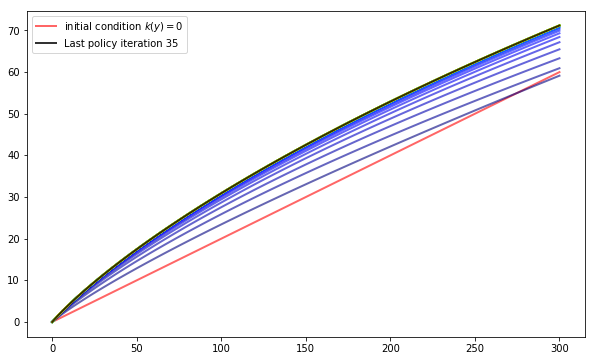

In [3]:
## Solving and Running the Model

EIAM = Euler_Infinite_Period_Deterministic_Agent_Model(y_max = 300,y_grid_size= 100)
EIAM.solve_policy_function()
EIAM.interpolate_k(100)

### 2.2. With Government Contract

#### 2.2.1. Derivation of Euler Equations

**NOTE:** For complete mathematical proof, see the [Dynamic Programming Squared Model_DRAFT.pdf](https://github.com/iamsurajkumar/Dynamic_Programming_Squared_Model/blob/master/Dynamic%20Programming%20Squared%20Model_DRAFT.pdf)

**Objective**
\begin{align}
		&w_t(y_t) =  
			\underset{x_t,k_t}{\text{max}} \left\{
			f_t(y_t,x_t) + \beta w_{t+1}(y_{t+1})
			\right\} \\
		&\text{such that } v(y_t) = h(y_t,k_t) + \beta * v_{t+1}(y_{t+1}) \geq v^*_t(y_t) \label{eq:deter_vstar_con} \\
		& y_{t+1} = G_t(y_t,x_t,k_t)
\end{align}

**Lagrangian Equation**
\begin{align}
	\mathcal{L} = w_t(y_t) = 
		f_t(y_t,x_t) + \beta w_{t+1}(y_{t+1})+
		\lambda_t \left[
			h_t(y_t,k_t) + \beta * v_{t+1}(y_{t+1}) - v^*_t(y_t)
		\right]  
\end{align} 

**First Order Conditions**
\begin{align}
		& \pd{\mathcal{L}}{x_t} = 
			\pd{f_t}{k_t} + \beta * \pd{w_{t+1}}{y_{t+1}}* \pd{y_{t+1}}{x_t} + \lambda_t * \beta \pd{v_{t+1}}{y_{t+1}}* \pd{y_{t+1}}{x_t}
			= 0 \label{eq:lag_foc_with_govt_x}\\
		& \pd{\mathcal{L}}{k_t} =
			\beta * \pd{w_{t+1}}{y_{t+1}}*\pd{y_{t+1}}{k_t} +
				\lambda_t \left[
					\pd{h_t}{k_t} + 
					\beta * \pd{v_{t+1}}{y_{t+1}}*\pd{y_{t+1}}{k_t}
				\right] = 0 \label{eq:lag_foc_with_govt_k}
\end{align}

**Solutions**

For $\lambda_t, \pd{w_{t+1}}{y_{t+1}}, \beta \pd{v(y_{t+1})}{y_{t+1}} and \pd{v^*_t}{y_t}$

\begin{align}
    &\lambda_t = \frac{\pd{f_t}{x_t}*\pd{y_{t+1}}{k_t}}
                        {\pd{y_{t+1}}{x_t}*\pd{h_t}{k_t}} \; ; \;
    w'_{t+1}(y_{t+1}) = \pd{w_{t+1}}{y_{t+1}} = \pd{f_{t+1}}{y_{t+1}} -
                \frac{ \pd{f_{t+1}}{x_{t+1}} * \pd{y_{t+2}}{y_{t+1}}}
                    {\pd{y_{t+2}}{x_{t+1}}} +
                \frac{ \pd{f_{t+1}}{x_{t+1}} * \pd{y_{t+2}}{k_{t+1}}}
                    {\pd{y_{t+2}}{x_{t+1}}*\pd{h_{t+1}}{k_{t+1}}}
                \left[ 
                \pd{h_{t+1}}{y_{t+1}} - v'^*(y_{t+1})
                \right] \\  
    & \beta \pd{v(y_{t+1})}{y_{t+1}} =
        \frac{1}{\pd{y_{t+1}}{y_t}}
        \left[
            \pd{v^*_t(y_t)}{y_t} - \pd{h_t(y_t,k_t)}{y_t}
        \right] \; ; \; 
      \pd{v^*_t}{y_t} = \pd{h_t}{y_t} - \pd{h_t}{k_t}*
					  \frac{\pd{y_{t+1}}{y_t}}
					  {\pd{y_{t+1}}{k_t}}       
\end{align}

#### 2.2.2. CODE

In [11]:
class Euler_Infinite_Period_Deterministic_Principal_Model:
    """
    This class contains the parameters of Deterministic Dynamic Programming Squared Model in Infinite Periods
    with government(principal) role. It solves for optimal k value for a given array of state value(y_grid).
    It uses scipy FSOLVE algorithm to solve for k_{t+1} and k_{t+1} in euler equation given k_{t},x_{t} and y_{t}
    """
    def __init__(self,
                 β = 0.9,
                 τ = 0.3,
                 α = 0.9,
                 δ = 0.5,
                 θ = 0.5,
                 a = 10,
                 b = 5,
                 y_min = 1e-5,
                 y_max = 200,
                 y_grid_size = 100,
                ):
        """
        Creates Instance of Dynamic Programming Squared Model based on Euler Equations
        --------------------------------
        Parameters are defined as below
        --------------------------------
        #Model Parameters
        α: relates the y(t) with y(t-1)
        δ: power of k in state function G_t(y_t,x_t,k_t)
        θ: power of x in state function G_t(y_t,x_t,k_t)
        a: coeff. of x in state function G_t(y_t,x_t,k_t)
        b: coeff. of k in state function G_t(y_t,x_t,k_t)
        β: discount factor of agent utility
        τ: tax rate of the government contract
        
        ### State Paramters
        y_min: minimum y (state) value to consider 
        y_max: maximum y (state) value to consider 
        y_grid_size: No of points to select between y_min and y_max
    
        
        
        """
        #### Assigning Parameters
        
        # Model Parameters
        self.β, self.τ = β, τ
        
        # State Function G Parameters assignement
        self.α, self.δ, self.θ, self.a, self.b = α, δ, θ, a, b
        
        #Y Grid State Allocation
        self.y_min, self.y_max, self.y_grid_size  = y_min, y_max, y_grid_size
        self.y_grid = np.linspace(self.y_min, self.y_max, self.y_grid_size)
    
        
    def G(self,y,x,k):
        """
        State Function G_t(y_t,x_t,k_t)
        """
        return (y**self.α + self.a * x**self.θ + self.b * k**self.δ)#*self.shocks

    def p_y_k(self,k):
        """
        Partial derivative of y_{t+1} wrt k_t
        """
        return self.b * self.δ/( k**( 1-self.δ ) )

    def p_y_y(self,y):
        """
        Partial derivative of y_{t+1} wrt y_t
        """
        return self.α/y**(1-self.α)
    def p_y_x(self,x):
        """
        Partial derivative of y_{t+1} wrt x_t
        """
        return (self.a*self.θ)/ ( x**(1-self.θ) )

    # Principal Utility Partial Derivatives
    def p_f_x(self, y, x):
        """
        Partial derivative of f(y_t,x_t) wrt x_t
        """
        return -1/(self.τ*y - x)

    def p_f_y(self, y, x):
        """
        Partial derivative of f(y_t,x_t) wrt y_t
        """
        return self.τ/(self.τ*y - x)

    # Agent Utility Partial Derivatives
    def p_h_k(self, y, k):
        """
         Partial derivative of h(y_t,k_t) wrt k_t
        """
        return -1/((1-self.τ)*y-k)

    def p_h_y(self, y, k):
        """
        Partial derivative of h(y_t,k_t) wrt y_t
        """
        return (1-self.τ)/( (1-self.τ)*y-k )
    
    # Agent Value Function Partial Derivatives
    
    def hstar_prime(self, y, k):
        return 1/(y - k)
    
    def kstar_grid_func(self):
        """
        Creates a kstar grid values
        """
        eiam = Euler_Infinite_Period_Deterministic_Agent_Model(β = self.β ,
                                                               α = self.α,
                                                               δ =  self.δ,
                                                               θ = self.θ,
                                                               a = self.a,
                                                               b = self.b,
                                                               y_min = self.y_min, 
                                                               y_max =self.y_max, 
                                                               y_grid_size = self.y_grid_size)
        eiam.solve_policy_function(tol = 1e-6,show_graph = False)
        self.kstar_grid = eiam.k_grid
        
    def p_vstar_y(self, y): 
        """
        Partial Derviative of v*(y) wrt y
        """
        k = np.interp(y, self.y_grid, self.kstar_grid)
        return self.hstar_prime(y,k) * ( 1 + self.p_y_y(y)/self.p_y_k(k) )
    
    def p_v_y(self, y, k):
        """
        Partial Derviative of v(y) wrt y
        """
        return 1/self.β * 1/self.p_y_y(y) * ( self.p_vstar_y(y) - self.p_h_y(y,k) )

    # Contraints 
    def lambda_t(self, y, x, k):
        """
        Returns the values λ_t
        """
        return ( self.p_f_x(y,x)*self.p_y_k(k) )/( self.p_y_x(x) * self.p_h_k(y,k) )

    # Principal Value Function Partial Derivatives
    def p_w_y(self, y, x, k):
        """
        Parital Derivative of w(y_t) wrt y_t
        """
        return (
                self.p_f_y(y,x) 
               - ( self.p_f_x(y,x)*self.p_y_y(y) )/self.p_y_x(x) 
               + (self.p_f_x(y,x)*self.p_y_k(k))/(self.p_y_x(x)*self.p_h_k(y,k))*(self.p_h_y(y,k) - self.p_vstar_y(y) )
               )
    def x_foc(self, y_next, k_next, x_next, y, x, k):
        """
        Lagrangian FOC wrt to x
        """
        return (
                self.p_f_x(y,x) 
                + self.β * self.p_w_y(y_next,x_next,k_next) * self.p_y_x(x)
                + (self.lambda_t(y,x,k) * self.β * self.p_v_y(y,k) * self.p_y_x(x)  ) 
               )

    def k_foc(self, y_next, k_next, x_next, y, x, k):
        """
        Lagrangian FOC wrt to k
        """
        return ( 
                self.β * self.p_w_y(y_next,x_next,k_next) * self.p_y_k(k) 
                + self.lambda_t(y,x,k)
                * ( self.p_h_k(y,k) + self.β * self.p_v_y(y,k) * self.p_y_k(k) ) 
               )

    def coleman_operator_principal(self, k_grid, x_grid, tol = 1e-9):
        """
        Applies the coleman operator on k grid and x grid, tol is used in fsolve
        
        """
        g_k = k_grid
        g_x = x_grid

        g_k_func = lambda z: np.interp(z, self.y_grid, k_grid)
        g_x_func = lambda z: np.interp(z, self.y_grid, x_grid)

        def foc(pars,y):
            k,x = pars
            y_next = self.G(y,x,k)
            k_next = g_k_func(y_next)
            x_next = g_x_func(y_next)

            F = np.zeros(2)
            F[0] = self.k_foc(y_next, k_next, x_next, y, x, k)
            F[1] = self.x_foc(y_next, k_next, x_next, y, x, k)
            return F 

        for i, y in enumerate(self.y_grid):
            ans = fsolve(foc,
                         x0 =[ (1-self.τ)*y*0.1, self.τ*y*0.1 ],
                         args = (y),xtol= tol)
            g_k[i] = ans[0]
            g_x[i] = ans[1]

        return g_k,g_x

    def solve_policy_function_principal(self,
                                   solve_tolerance = 1e-9,
                                   max_iter = 50):
        """
        Solves the Model, max_iter defines the max number iterations to be done for coleman operator,
        solve_tolerance is used in fsolve in function self.coleman_operator_principal()
        """
        
        #Generating kstar grid values
        self.kstar_grid_func()
        
        # Initial k and x grids
        k = {}
        x = {}
        k_grid = self.y_grid * ( 1-self.τ ) * 0.5
        x_grid = self.y_grid * (self.τ) * 0.5

        #Initial Plot
        fig, ax = plt.subplots(ncols = 2,figsize=(10, 6))
        lb = 'initial condition$'
        ax[0].plot(self.y_grid, k_grid, color = 'red', lw=2, alpha=0.6, label=lb);
        ax[1].plot(self.y_grid, x_grid, color = 'red', lw=2, alpha=0.6, label=lb);
        
        #Looping Paramters
        j = 0
      
        
        #Looping and plotting
        while j < max_iter:
            new_k_grid, new_x_grid = self.coleman_operator_principal(
                                                                k_grid, 
                                                                x_grid, 
                                                                tol = solve_tolerance
                                                                )
            k_grid[:], x_grid[:] = new_k_grid, new_x_grid
            ax[0].plot(self.y_grid, new_k_grid, color=plt.cm.jet(j / max_iter), lw=2, alpha=0.6);
            ax[1].plot(self.y_grid, new_x_grid, color=plt.cm.jet(j / max_iter), lw=2, alpha=0.6);
            j = j + 1
        
        #Last Policy Plot
        lb = 'Last policy iterations {}'.format(j)
        ax[0].plot(self.y_grid, k_grid, 'black', lw=2, alpha=0.8, label=lb);
        ax[1].plot(self.y_grid, x_grid, color = 'black', lw=2, alpha=0.6, label=lb);

        ### Plots Setup
        
        # Axis Limits
        
        # y limits
        ax[0].set_ylim(0,max(k_grid)+1)
        ax[1].set_ylim(0,max(x_grid)+1)
        
        # x limits
        ax[0].set_xlim(0,max(self.y_grid)+1)
        ax[1].set_xlim(0,max(self.y_grid)+1)
        
        ## labels
        # x label
        ax[0].set_xlabel('Y')
        ax[1].set_xlabel('Y')
        
        # y label
        ax[0].set_ylabel('K')
        ax[1].set_ylabel('X')
        
        # Titles
        ax[0].set_title('K Policy Iterations')
        ax[1].set_title('X Policy Iterations')
        
        # Legends
        ax[0].legend(loc='upper left')
        ax[1].legend(loc='upper left')

        plt.show();
        
        ####  Storing the Final Values in Class
        self.k_grid = k_grid
        self.x_grid = x_grid
        
        ## Creating Value Functions and Plots
        self.create_value_functions_and_plots()
        
    def kstar(self,y):
        """
        Returns optimal value of k in for v*(y)
        """
        return interp1d(self.y_grid, self.kstar_grid,fill_value = 'extrapolate')(y)
        
    def vstar_value(self, y, tol = 1e-5):
        """
        Returns v*(y): Agent value without government contract
        """
        v = {}
        i = 0
        v[i] = 0
        increment = tol + 1
        while increment > tol:
            periodic_utility = self.β**i * np.log(y - self.kstar(y))
            v[i+1] = v[i] + periodic_utility
            increment = np.abs( v[i+1]-v[i] )
            y = self.G(y, 0, self.kstar(y))
            i = i + 1
        return v[i]
    
    def vstar_value_function(self):
        """
        Returns the v* value function
        """
        v = np.zeros_like(self.y_grid)
        for i,y in enumerate(self.y_grid):
            v[i] = self.vstar_value(y)
        self.vstar_value_grid = v

    def k(self,y):
        """
        Returns optimal k for given value of y with government contract
        """
        return interp1d(self.y_grid, self.k_grid,fill_value = 'extrapolate')(y)
    
    def x(self,y):
        """
        Returns optimal k for given value of y with government contract
        """
        return interp1d(self.y_grid,self.x_grid, fill_value = 'extrapolate')(y)
    
    def v_and_w_value(self,y,tol = 1e-5):
        """
        Returns agent present discounted utility and principal present discounted utility for 
        a given value of y with contract
        
        """
        v = {}
        w = {}
        i = 0
        v[i] = 0
        w[i] = 0
        increment = tol + 1
        while increment > tol:
            periodic_agent_utility = self.β**i * np.log( (1-self.τ)*y - self.k(y) )
            periodic_principal_utility = self.β**i * np.log( self.τ*y - self.x(y) )
            v[i+1] = v[i] + periodic_agent_utility
            w[i+1] = w[i] + periodic_principal_utility
            increment = max( np.abs(v[i+1]-v[i]), np.abs(w[i+1]-w[i]) )
            y_next = self.G(y,self.x(y),self.k(y))
            i = i + 1 
        return v[i], w[i]
    
    def v_and_w_value_function(self):
        """
        Returns agent and principal value function with contract
        """
        v = np.zeros_like(self.y_grid)
        w = np.zeros_like(self.y_grid)
        for i,y in enumerate(self.y_grid):
            v[i], w[i] = self.v_and_w_value(y)
        self.v_value_grid = v
        self.w_value_grid = w
    
    def create_value_functions_and_plots(self):
        """
        Creates the value function with and without contract
        """
        
        self.vstar_value_function()
        self.v_and_w_value_function()
        
        fig, ax = plt.subplots(figsize = (10,6));
        ax.plot(self.y_grid, self.vstar_value_grid, 'black', lw=2, alpha=0.8, 
                   label='Agent Value Function without Government contract');
        ax.plot(self.y_grid, self.v_value_grid, 'red', lw=2, alpha=0.8, 
                   label='Agent Value Function with Government Contract');
        ax.set_ylim(0, max ( np.max(self.vstar_value_grid),np.max(self.v_value_grid) ) );
        ax.set_xlim(0,self.y_max);
        ax.set_ylabel('Value')
        ax.set_xlabel('Y ')
        ax.set_title('Agent Value Function')
        ax.legend(loc='lower right');
        plt.show;
        
        fig, ax = plt.subplots(figsize = (10,6));
        ax.plot(self.y_grid, self.w_value_grid, 'blue', lw=2, alpha=0.8, 
                   label='Principal Value Function');
        ax.set_ylim(0,np.max(self.w_value_grid));
        ax.set_xlim(0,self.y_max);
        ax.set_ylabel('Value')
        ax.set_xlabel('Y ')
        ax.set_title('Principal Value Function')
        ax.legend(loc='lower right');
        plt.show;
        

In [12]:
EIPM = Euler_Infinite_Period_Deterministic_Principal_Model(y_max= 200,y_grid_size= 50)

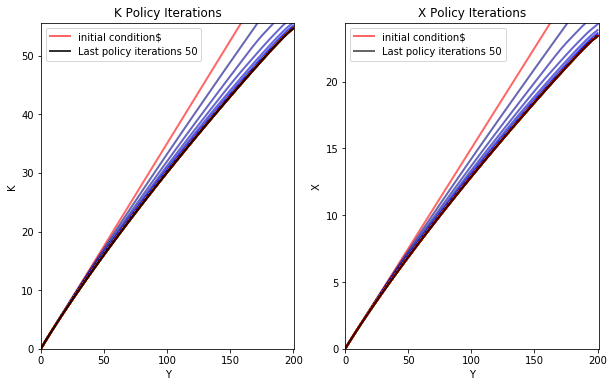

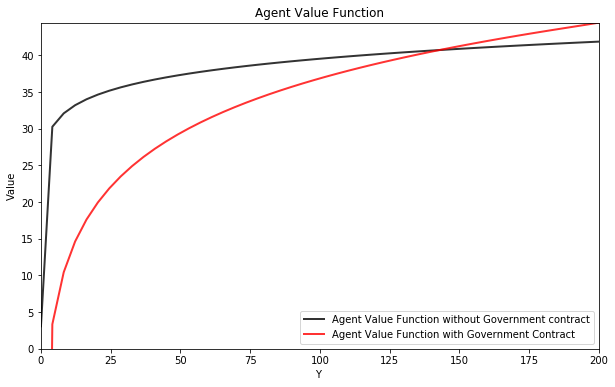

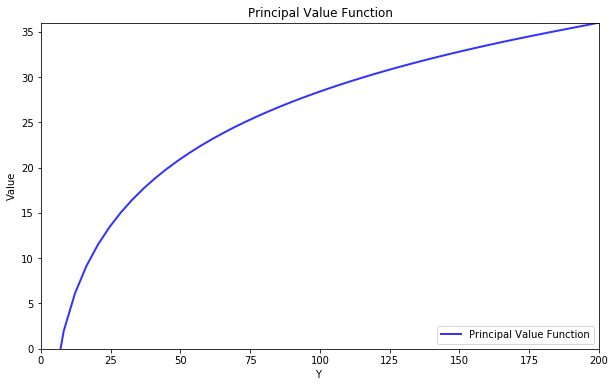

In [13]:
EIPM.solve_policy_function_principal(max_iter = 50)

In [10]:
EIPM.vstar_value(100)
EIPM.v_and_w_value(100)

39.55064618275722

(36.872515200116069, 28.399556446199782)

## 3. Conclusion


### 3.1. SOLUTION CHECK

**No Government Contract**

Given $y_0  = 100$, the agent utility is
\begin{align*}
&v^* = 39.54 \text{ from Finite state model of 100 Periods}\\
&v^* = 39.55 \text{ from Infinite Horizon model}
\end{align*}

** With Government Contract**

Given $y_0 = 100$, Finite Period Horizon Model (for $n = 50$) yields $v = 39.738$ and $w = 34.651$ while the Infinite Period Horizon Model based on Euler Equation yields $v = 36.87$ and $w = 28.399$.


*Reasons for divergence between solutions of finite period horizon model and Infinite period model(Euler Equation Model)*

1. Infinite period Model uses python non linear equation solution method scipy.optimize.fsolve. Fsolve with one control variable yields a single point solution. But while using fsolve with two control variables leads to multiple solutions due non linear nature of the problem. Thus the answer differs based on two methods

2. Finite Period Model works better as it try to search for global optima by using randomization in initial starting point $x_0$. No such randomization in $x_0$ have been done for fsolve in euler method.


These above two points also explains why the slopes of agent value function differs with or without government contract in infinite horizon euler equation model. 


**NOTE: STOCHASTIC DYNAMIC PROGRAMMING MODEL INFINITE HORIZON MODEL**
The mathetmatical analysis of stochastic setting is already been done in the [Dynamic Programming Squared Model_DRAFT.pdf](https://github.com/iamsurajkumar/Dynamic_Programming_Squared_Model/blob/master/Dynamic%20Programming%20Squared%20Model_DRAFT.pdf). The expectation in stochastic setting can by done by numerical integration and linear interpolation. It would be done in future iterations of this notebook.